In [76]:
# import exploratory data analysis (EDA)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # filling missing data
from sklearn.preprocessing import OneHotEncoder # strings to numerical

# Models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Other models
from xgboost import XGBClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

import missingno as msno


In [54]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("gender_submission.csv")

## Data Dictionary

*survival, Survival, 0 = No, 1 = Yes

*pclass, ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd

*sex	Sex	

*Age	Age in years	

*sibsp	# of siblings / spouses aboard the Titanic	

*parch	# of parents / children aboard the Titanic	

*ticket	Ticket number	

*fare	Passenger fare	

*cabin	Cabin number	

*embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [117]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Montvila
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Graham
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Johnston
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Behr


In [118]:
# add a column with last names to idenify family members
train['LastName'] = train['Name'].str.split(',', expand=True)[0]
test['LastName'] = test['Name'].str.split(',', expand=True)[0]

#put the train and test data together to process columns together and seperate again later
ds = pd.concat([train, test])

sur = list()
died = list()

# iterate over dataframe to identify how many family members all survived or all died.
for index, row in ds.iterrows():
    s = ds[(ds['LastName']==row['LastName']) & (ds['Survived']==1)]
    d = ds[(ds['LastName']==row['LastName']) & (ds['Survived']==0)]
    s=len(s)
    if row['Survived'] == 1:
        s-=1
    d=len(d)
    if row['Survived'] == 0:
        d-=1
    sur.append(s)
    died.append(d)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Ware


In [ ]:
ds['FamilySurvived'] = sur
ds['FamilyDied'] = died
ds['FamilySize'] = ds['SibSp'] + ds['Parch'] + 1
ds['IsAlone'] = 0
ds.loc[ds['FamilySize'] == 1, 'IsAlone'] = 1
ds['Fare'] = ds['Fare'].fillna(train['Fare'].median())
ds['Embarked'] = ds['Embarked'].fillna('Q')


In [98]:




    


train = ds[ds['Survived'].notnull()]
test = ds[ds['Survived'].isnull()]
test = test.drop(['Survived'], axis=1)

train['rich_woman'] = 0
test['rich_woman'] = 0
train['men_3'] = 0
test['men_3'] = 0

train.loc[(train['Pclass']<=2) & (train['Sex']=='female'), 'rich_woman'] = 1
test.loc[(test['Pclass']<=2) & (test['Sex']=='female'), 'rich_woman'] = 1
train.loc[(train['Pclass']==3) & (train['Sex']=='male'), 'men_3'] = 1
test.loc[(test['Pclass']==3) & (test['Sex']=='male'), 'men_3'] = 1

train['rich_woman'] = train['rich_woman'].astype(np.int8)
test['rich_woman'] = test['rich_woman'].astype(np.int8)

train["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in train['Cabin']])
test['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in test['Cabin']])

for cat in ['Pclass', 'Sex', 'Embarked', 'Cabin']:
    train = pd.concat([train, pd.get_dummies(train[cat], prefix=cat)], axis=1)
    train = train.drop([cat], axis=1)
    test = pd.concat([test, pd.get_dummies(test[cat], prefix=cat)], axis=1)
    test = test.drop([cat], axis=1)
    
train = train.drop(['PassengerId', 'Ticket', 'LastName', 'SibSp', 'Parch', 'Sex_male', 'Name'], axis=1)
test =  test.drop(['PassengerId', 'Ticket', 'LastName', 'SibSp', 'Parch', 'Sex_male', 'Name'], axis=1)

train = train.fillna(-1)
test = test.fillna(-1)

train.head()
'''

'\nsur = list()\ndied = list()\n\nfor index, row in ds.iterrows():\n    s = ds[(ds[\'LastName\']==row[\'LastName\']) & (ds[\'Survived\']==1)]\n    d = ds[(ds[\'LastName\']==row[\'LastName\']) & (ds[\'Survived\']==0)]\n    s=len(s)\n    if row[\'Survived\'] == 1:\n        s-=1\n    d=len(d)\n    if row[\'Survived\'] == 0:\n        d-=1\n    sur.append(s)\n    died.append(d)\n    \nds[\'FamilySurvived\'] = sur\nds[\'FamilyDied\'] = died\nds[\'FamilySize\'] = ds[\'SibSp\'] + ds[\'Parch\'] + 1\nds[\'IsAlone\'] = 0\nds.loc[ds[\'FamilySize\'] == 1, \'IsAlone\'] = 1\nds[\'Fare\'] = ds[\'Fare\'].fillna(train[\'Fare\'].median())\nds[\'Embarked\'] = ds[\'Embarked\'].fillna(\'Q\')\n\ntrain = ds[ds[\'Survived\'].notnull()]\ntest = ds[ds[\'Survived\'].isnull()]\ntest = test.drop([\'Survived\'], axis=1)\n\ntrain[\'rich_woman\'] = 0\ntest[\'rich_woman\'] = 0\ntrain[\'men_3\'] = 0\ntest[\'men_3\'] = 0\n\ntrain.loc[(train[\'Pclass\']<=2) & (train[\'Sex\']==\'female\'), \'rich_woman\'] = 1\ntest.loc[(te

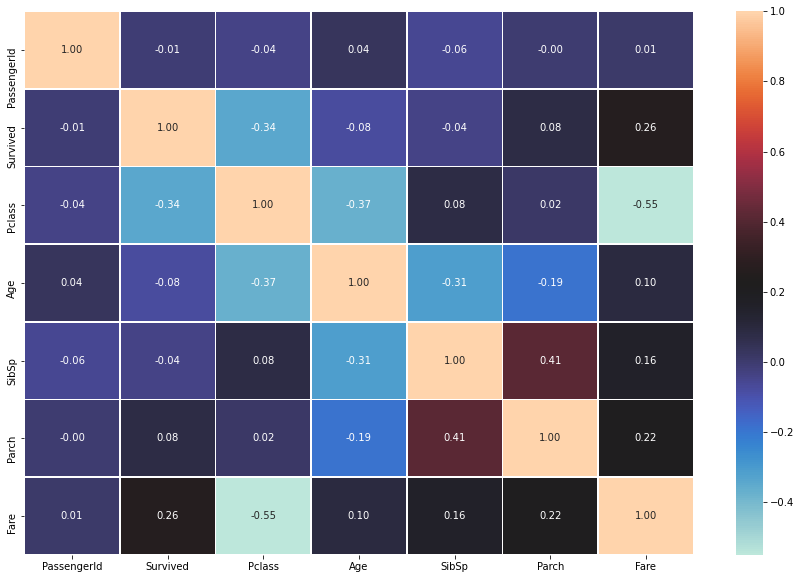

In [64]:
# correlation matrix

corr_matrix = train.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, 
                 annot=True, 
                 linewidths=0.5, 
                 fmt=".2f",
                cmap="icefire")

In [56]:
train['Ticket'].nunique()

681

In [57]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [58]:
train['Ticket'].value_counts()

1601                 7
CA. 2343             7
347082               7
3101295              6
347088               6
                    ..
330959               1
STON/O 2. 3101294    1
349209               1
365222               1
315153               1
Name: Ticket, Length: 681, dtype: int64

<AxesSubplot:>

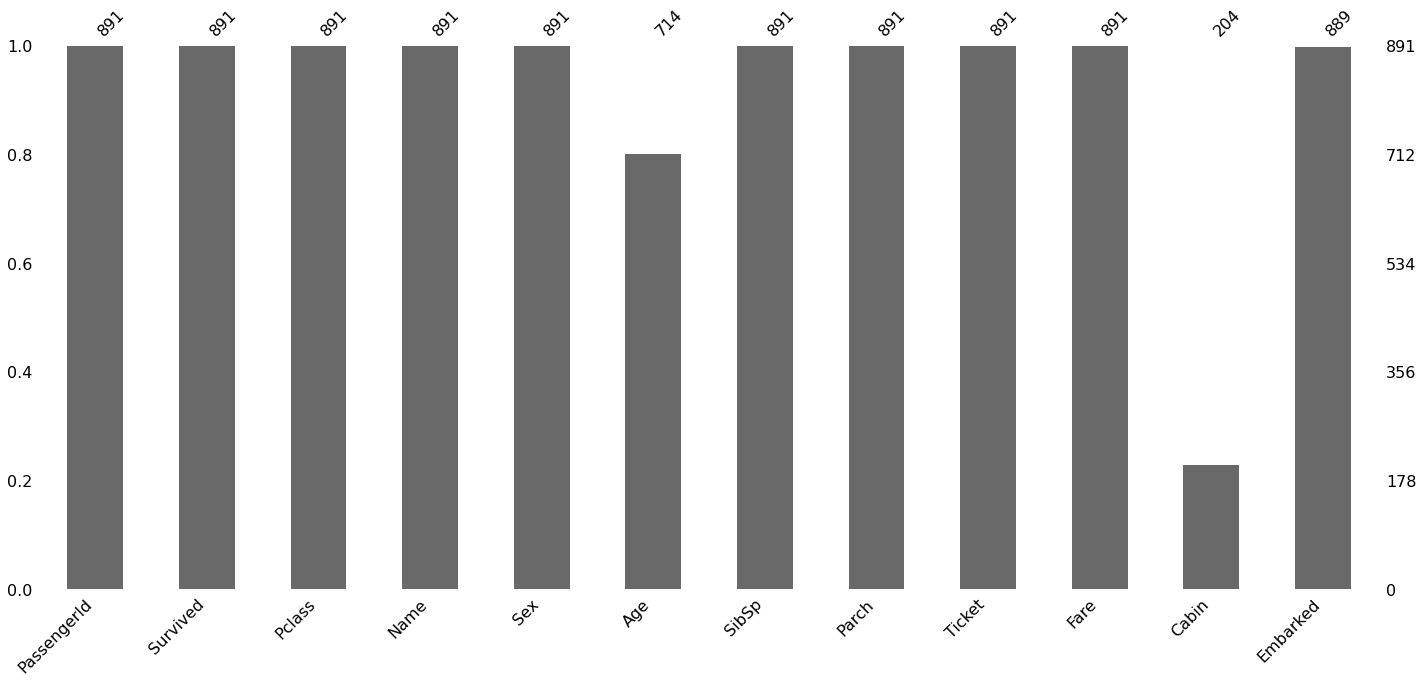

In [59]:
msno.bar(train)

In [60]:
train['Age'].mean(), train["Age"].median()

(29.69911764705882, 28.0)

In [61]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [62]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Findings in data
* Ticket has 691 unique values. There are therefore some ticket numbers with max value_counts up to 7. Leave this column out for now.
* Two data points missing in Embarked. Fill with the most common of the three (S).
* 20 % of data missing for age. Leave column in for now and fill with median().

In [52]:
## PREPROCESSING AND MODEL PIPELINE

# Define different features and transformer pipeline
categorial_features = ['Sex', 'Embarked'] # There are no missing values for Sex, therefore imputer can be placed together with encoder here.
categorical_transformer = Pipeline(steps=[
                                        ('imputer', SimpleImputer(strategy='constant', fill_value='S')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])

numeric_features = ['Age']
numeric_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy='median'))
                                     ])

# Setup preprocessing steps
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorial_features), 
                                               ('num', numeric_transformer, numeric_features)
                                              ])

# Creating a preprocessing and modelling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestClassifier())])






In [79]:
models = {"Logistic Regression": Pipeline(steps=[('preprocessor', preprocessor), ('model', LogisticRegression())]),
         "KNN": Pipeline(steps=[('preprocessor', preprocessor), ('model', KNeighborsClassifier())]),
         "Random Forest": Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestClassifier())]),
         "XGB": Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBClassifier())])}

# create function to fit and score models

def fit_and_score(models, X_train, y_train, X_test, y_test):
    '''
    Fits and evaluates given machine learning models.
    models: a dict of machine learning models
    X_train: training data no labels
    X_test: testing data no labels
    y_train: training labels
    y_test: test labels
    '''
    #set random seed
    np.random.seed(42)
    # make dict to record model scores
    model_scores = {}
    # loop through models
    for name, model in models.items():
        # fit model to data
        model.fit(X_train, y_train)
        # evaluate model and append scores to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [80]:
model_scores = fit_and_score(models, X_train, y_train, X_test, y_test)
model_scores

{'Logistic Regression': 0.7653631284916201,
 'KNN': 0.7430167597765364,
 'Random Forest': 0.7262569832402235,
 'XGB': 0.7430167597765364}

In [72]:
X = train.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [65]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='S',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age'])])),
                ('model', RandomForestClassifier())])

In [66]:
y_preds = model.predict(X_test)

In [67]:
y_preds

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [68]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_preds})
output.to_csv('RFC_1_submission.csv', index=False)

In [90]:
# Use gridsearch CV on Logistic Regresssion

pipe_grid_log_reg = {"model__C": np.logspace(-4, 4, 30),
               "model__solver": ["liblinear", "saga"],
               "model__penalty":['l1', 'l2', 'elasticnet']}

model = models['Logistic Regression']

gs_model = GridSearchCV(model, pipe_grid_log_reg, cv=5, verbose=2)
gs_model.fit(X_train, y_train)


Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] model__C=0.0001, model__penalty=l1, model__solver=liblinear .....
[CV]  model__C=0.0001, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.0001, model__penalty=l1, model__solver=liblinear .....
[CV]  model__C=0.0001, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=l1, model__solver=liblinear .....
[CV]  model__C=0.0001, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=l1, model__solver=liblinear .....
[CV]  model__C=0.0001, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=l1, model__solver=liblinear .....
[CV]  model__C=0.0001, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=l1, model__solver=saga ..........
[CV]  model__C=0.0001, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.0001, model__p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  model__C=0.0001, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=0.0001, model__penalty=l2, model__solver=liblinear .....
[CV]  model__C=0.0001, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=l2, model__solver=liblinear .....
[CV]  model__C=0.0001, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=l2, model__solver=liblinear .....
[CV]  model__C=0.0001, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=l2, model__solver=liblinear .....
[CV]  model__C=0.0001, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=l2, model__solver=saga ..........
[CV]  model__C=0.0001, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.0001, model__penalty=l2, model__solver=saga ..........
[CV]  model__C=0.0001, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.0

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.0001, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.0001, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0001, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=0.0001, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0001, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=elasticnet, model__solver=liblinear 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.0001, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0001, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0001, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0001, model__penalty=elasticnet, model__solver=saga ..
[CV]  model__C=0.0001, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0001, model__penalty=elasticnet, model__solver=saga ..
[CV]  model__C=0.0001, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0001, model__penalty=elasticnet, model__solver=saga ..
[CV]  model__C=0.0001, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0001, model__penalty=elasticnet, model__solver=saga ..

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\mod


[CV]  model__C=0.0001, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0001, model__penalty=elasticnet, model__solver=saga ..
[CV]  model__C=0.0001, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.00018873918221350977, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.00018873918221350977, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.00018873918221350977, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.00018873918221350977, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.00018873918221350977, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.00018873918221350977, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.00018873918221350977, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.00018873918221350977, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.00018873918221350977, model_

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.00018873918221350977, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.00018873918221350977, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.00018873918221350977, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.00018873918221350977, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.00018873918221350977, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.00018873918221350977, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.00018873918221350977, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.00018873918221350977, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.00018873918221350977, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.00018873918221350977, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.0001887391822

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.0003562247890262444, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.0003562247890262444, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.0003562247890262444, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.0003562247890262444, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.0003562247890262444, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.0003562247890262444, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.0003562247890262444, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.0003562247890

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_

[CV]  model__C=0.0003562247890262444, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.0003562247890262444, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.0003562247890262444, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.0003562247890262444, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.0003562247890262444, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.000356

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\mod

[CV]  model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.0003562247890262444, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0006723357536499335, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.0006723357536499335, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0006723357536499335, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.0006723357536499335, model__penalty=l1, model__solver=liblinear, total=   0.0

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_

[CV]  model__C=0.0006723357536499335, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.0006723357536499335, model__pen

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.0006723357536499335, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.0012689610031679222, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.0012689610031679222, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0012689610031679222, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.0012689610031679222, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.0012689610031679222, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.0012689610031679222, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV]

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV] model__C=0.002395026619987486, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.002395026619987486, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.002395026619987486, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.002395026619987486, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.002395026619987486, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.002395026619987486, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l1, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.002395026619987486, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.002395026619987486, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.002395026619987486, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.002395026619987486, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.002395026619987486, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.002395026619987486, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=l2, model__sol

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.002395026619987486, model__penalty=elasticnet, model__solver=saga, total=

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.004520353656360241, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.004520353656360241, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.004520353656360241, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.004520353656360241, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.004520353656360241, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.004520353656360241, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.004520353656360241, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.004520353656360241, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.004520353656360241, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.004520353656360241, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.004520353656360241, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.004520353656360241, mode

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.004520353656360241, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.004520353656360241, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.004520353656360241, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.008531678524172805, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.008531678524172805, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.008531678524172805, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.008531678524172805, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.00853

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.008531678524172805, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.008531678524172805, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.008531678524172805, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.008531678524172805, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.008531678524172805, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.008531678524172805, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.008531678524172805, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=l2, model__sol

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.008531678524172805, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.008531678524172805, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=liblin

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV] model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.008531678524172805, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.01610262027560939, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.01610262027560939, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.01610262027560939, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.01610262027560939, mode

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.01610262027560939, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.01610262027560939, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.01610262027560939, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.01610262027560939, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.01610262027560939, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.01610262027560939, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.01610262027560939, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=l2, model__solver=liblinear 
[CV]  m

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.01610262027560939, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.01610262027560939, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.01610262027560939, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.01610262027560939, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.01

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.01610262027560939, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.03039195382313198, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.03039195382313198, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.03039195382313198, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.03039195382313198, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.03039195382313198, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.03039195382313198, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.03039195382313198, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=l2, model__solver=liblinear 
[CV]  m

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.03039195382313198, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.03039195382313198, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.03039195382313198, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.03039195382313198, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.03039195382313198, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.03039195382313198, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.03039195382313198, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.03039195382313198, model__penalty=elasticnet, model

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.05736152510448681, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.05736152510448681, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.05736152510448681, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.05736152510448681, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.05736152510448681, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.05736152510448681, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l1, model__

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.05736152510448681, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.05736152510448681, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.05736152510448681, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.05736152510448681, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.05736152510448681, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.05736152510448681, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.05736152510448681, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l2, mo

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.05736152510448681, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.05736152510448681, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.05736152510448681, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.05736152510448681, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.05736152510448681, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.05736152510448681, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.05736152510448681, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.05736152510448681, model__pe

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\mod

[CV]  model__C=0.05736152510448681, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.05736152510448681, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.05736152510448681, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.05736152510448681, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.1082636733874054, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.1082636733874054, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.1082636733874054, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.1082636733874054

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.1082636733874054, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.1082636733874054, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.1082636733874054, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.1082636733874054, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.1082636733874054, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.1082636733874054, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.10

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.1082636733874054, model__penalty=elasticnet, model__s

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.1082636733874054, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.20433597178569418, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.20433597178569418, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.20433597178

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\mod

[CV] model__C=0.20433597178569418, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.20433597178569418, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.20433597178569418, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.20433597178569418, model__penalty=l1, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=0.20433597178569418, model__penalty=l1, model__solver=saga, total=   0.2s
[CV] model__C=0.20433597178569418, model__penalty=l1, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=0.20433597178569418, model__penalty=l1, model__solver=saga, total=   0.2s
[CV] model__C=0.20433597178569418, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.20433597178569418, model__penalty=l1, model__solver=saga, total=   0.2s
[CV] model__C=0.20433597178569418, model__penalty=l1, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=0.20433597178569418, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.20433597178569418, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=l2, model__solver=liblinear, total=   0.2s
[CV] model__C=0.20433597178569418, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=l2, model__solver=liblinear, total=   0.2s
[CV] model__C=0.20433597178569418, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=l2, model__solver=liblinear, total=   0.2s
[CV] model__C=0.20433597178569418, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.20433597178569418, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.20433597178569418, model__pena

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



[CV] model__C=0.20433597178569418, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.20433597178569418, model__penalty=l2, model__solver=saga, total=   0.2s
[CV] model__C=0.20433597178569418, model__penalty=l2, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=0.20433597178569418, model__penalty=l2, model__solver=saga, total=   0.2s
[CV] model__C=0.20433597178569418, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.20433597178569418, model__penalty=l2, model__solver=saga, total=   0.2s
[CV] model__C=0.20433597178569418, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.20433597178569418, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=liblinear 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(sel

[CV]  model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=saga, total=   0.1s
[CV] model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=saga, total=   0.1s
[CV] model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.20433597178569418, model__penalty=elasticnet, model__solver=saga, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l1, model__solver=liblinear 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\mod

[CV]  model__C=0.38566204211634725, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.38566204211634725, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=0.38566204211634725, model__penalty=l1, model__solver=saga, total=   0.2s
[CV] model__C=0.38566204211634725, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.38566204211634725, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.38566204211634725, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l1, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=0.38566204211634725, model__penalty=l1, model__solver=saga, total=   0.2s
[CV] model__C=0.38566204211634725, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__pena

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=0.38566204211634725, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.38566204211634725, model__penalty=l2, model__solver=saga, total=   0.2s
[CV] model__C=0.38566204211634725, model__penalty=l2, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=0.38566204211634725, model__penalty=l2, model__solver=saga, total=   0.3s
[CV] model__C=0.38566204211634725, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.38566204211634725, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=l2, model__solver=saga 
[CV]  model__C=0.38566204211634725, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=liblinear 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(sel

[CV]  model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.38566204211634725, model__penalty=elasticne

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=saga, total=   0.1s
[CV] model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.38566204211634725, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=0.7278953843983146, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l1, model__solver=liblinear 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\mod

[CV]  model__C=0.7278953843983146, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.7278953843983146, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.7278953843983146, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.7278953843983146, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l1, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.7278953843983146, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.7278953843983146, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=0.7278953843983146, model__penalty=l1, model__solver=saga 
[CV]  model__C=0.7278953843983146, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=l2, model__solver=liblinear 

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=0.7278953843983146, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=liblinear 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=0.7278953843983146, model__penalty=elasticnet, model__solver=saga

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\mod


[CV] model__C=1.3738237958832638, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l1, model__solver=saga 
[CV]  model__C=1.3738237958832638, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l1, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=1.3738237958832638, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l1, model__solver=saga 
[CV]  model__C=1.3738237958832638, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l1, model__solver=saga 
[CV]  model__C=1.3738237958832638, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l1, model__solver=saga 
[CV]  model__C=1.3738237958832638, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=l2, model__solver=liblinear 
[CV]  mod

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=1.3738237958832638, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=li

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=1.3738237958832638, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=2.592943797404667, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=2.592943797404667, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=2.592943797404667, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=l1, model__

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=2.592943797404667, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=2.592943797404667, model__penalty=l1, model__solver=saga 
[CV]  model__C=2.592943797404667, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=2.592943797404667, model__penalty=l1, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=2.592943797404667, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=2.592943797404667, model__penalty=l1, model__solver=saga 
[CV]  model__C=2.592943797404667, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=2.592943797404667, model__penalty=l1, model__solver=saga 
[CV]  model__C=2.592943797404667, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=l2, model__solver=liblinear 
[CV]  model

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] model__C=2.592943797404667, model__penalty=l2, model__solver=saga 
[CV]  model__C=2.592943797404667, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=2.592943797404667, model__penalty=l2, model__solver=saga 
[CV]  model__C=2.592943797404667, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=2.592943797404667, model__penalty=l2, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.p

[CV]  model__C=2.592943797404667, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=2.592943797404667, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=2.592943797404667, model__penalty=elasticnet, model__solver=liblinear, to

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=2.592943797404667, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=2.592943797404667, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=2.592943797404667, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=2.592943797404667, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=2.592943797404667, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=4.893900918477489, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=4.893900918477489, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=4.893900918477489, model__pe

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=4.893900918477489, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=l1, model__solver=saga 
[CV]  model__C=4.893900918477489, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=4.893900918477489, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=4.893900918477489, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=4.893900918477489, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=4.893900918477489, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=4.893900918477489, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=4.893900918477489, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=4.893900918477489, model__penalty=l2, model__solver=liblinear 
[

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=4.893900918477489, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=4.893900918477489, model__penalty=l2, model__solver=saga 
[CV]  model__C=4.893900918477489, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=4.893900918477489, model__penalty=l2, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\d

[CV]  model__C=4.893900918477489, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=4.893900918477489, model__penalty=l2, model__solver=saga 
[CV]  model__C=4.893900918477489, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=4.893900918477489, model__penalty=l2, model__solver=saga 
[CV]  model__C=4.893900918477489, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=4.893900918477489, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=4.893900918477489, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=4.893900918477489, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=4.893900918477489, model__

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\mod

[CV]  model__C=4.893900918477489, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=4.893900918477489, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=4.893900918477489, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=4.893900918477489, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=4.893900918477489, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=4.893900918477489, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=9.236708571873866, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=9.236708571873866, mod

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] model__C=9.236708571873866, model__penalty=l1, model__solver=saga 
[CV]  model__C=9.236708571873866, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=9.236708571873866, model__penalty=l1, model__solver=saga 
[CV]  model__C=9.236708571873866, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=l1, model__solver=saga 
[CV]  model__C=9.236708571873866, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=l1, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=9.236708571873866, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=9.236708571873866, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=9.236708571873866, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=9.236708571873866, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=9.236708571873866, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=9.236708571873866, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=9.236708571873866, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=9.236708571873866, model__penalty=l2, model__solver=sa

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=9.236708571873866, model__penalty=l2, model__solver=saga, total=   0.3s
[CV] model__C=9.236708571873866, model__penalty=elasticnet, model__solver=liblinear 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=9.236708571873866, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=9.236708571873866, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=9.236708571873866, model__penalty=elasticnet, model__solver=liblinear, total=   0.2s
[CV] model__C=9.236708571873866, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=9.236708571873866, model__penalty=elasticnet, model__solver=liblinear, total=   0.2s
[CV] model__C=9.236708571873866, model__penalty=elasticnet, model__solver=liblinear 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=9.236708571873866, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=9.236708571873866, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=9.236708571873866, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=9.236708571873866, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=9.236708571873866, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=9.236708571873866, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=9.236708571873866, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=9

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=17.433288221999874, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=17.433288221999874, model__penalty=l1, model__solver=saga 
[CV]  model__C=17.433288221999874, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=17.433288221999874, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=17.433288221999874, model__penalty=l2, model__solver=liblinear, total=   0.2s
[CV] model__C=17.433288221999874, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=17.433288221999874, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=17.433288221999874, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=17.433288221999874, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=17.433288221999874, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=17.433288221999874, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=17.433288221999874, model__penalty=l2, model__solver=

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=17.433288221999874, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=17.433288221999874, model__penalty=l2, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=17.433288221999874, model__penalty=l2, model__solver=saga, total=   0.3s
[CV] model__C=17.433288221999874, model__penalty=l2, model__solver=saga 
[CV]  model__C=17.433288221999874, model__penalty=l2, model__solver=saga, total=   0.2s
[CV] model__C=17.433288221999874, model__penalty=elasticnet, model__solver=liblinear 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(sel

[CV]  model__C=17.433288221999874, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=17.433288221999874, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=17.433288221999874, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=17.433288221999874, model__penalty=elasticnet, model__solver=liblinear 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=17.433288221999874, model__penalty=elasticnet, model__solver=liblinear, total=   0.3s
[CV] model__C=17.433288221999874, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=17.433288221999874, model__penalty=elasticnet, model__solver=liblinear, total=   0.1s
[CV] model__C=17.433288221999874, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=17.433288221999874, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=17.433288221999874, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=17.433288221999874, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=17.433288221999874, model__penalty=elasticnet, model__solver=saga 

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\mod


[CV]  model__C=17.433288221999874, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=17.433288221999874, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=17.433288221999874, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=17.433288221999874, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=17.433288221999874, model__penalty=elasticnet, model__solver=saga, total=   0.1s
[CV] model__C=17.433288221999874, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=17.433288221999874, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=32.90344562312671, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=32.90344562312671, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=32.90344562312671, m

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=32.90344562312671, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=32.90344562312671, model__penalty=l1, model__solver=saga 
[CV]  model__C=32.90344562312671, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=32.90344562312671, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=32.90344562312671, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=32.90344562312671, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=32.90344562312671, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=l2, model__solver=liblinear 
[

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=32.90344562312671, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=l2, model__solver=saga 
[CV]  model__C=32.90344562312671, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=32.90344562312671, model__penalty=l2, model__solver=saga 
[CV]  model__C=32.90344562312671, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=l2, model__solver=saga 
[CV]  model__C=32.90344562312671, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=32.90344562312671, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=32.90344562312671, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=elasticnet, model_

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=32.90344562312671, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=32.90344562312671, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=32.90344562312671, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=32.90344562312671, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=32.90344562312671, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=32.90344562312671, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=32.90344562312671, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=62.10169418

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=62.10169418915616, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=62.10169418915616, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=62.10169418915616, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=62.10169418915616, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=l2, model__solver=saga 
[CV]  model__C=62.10169418915616, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=l2, model__solver=saga 
[CV]  model__C=62.10169418915616, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=l2, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=62.10169418915616, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=l2, model__solver=saga 
[CV]  model__C=62.10169418915616, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=l2, model__solver=saga 
[CV]  model__C=62.10169418915616, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=62.10169418915616, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=62.10169418915616, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=62.10169418915616, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=62.10169418915616, model__

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=62.10169418915616, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=62.10169418915616, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=62.10169418915616, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=62.10169418915616, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=62.10169418915616, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=62.10169418915616, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=117.21022975334793, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=117.21022975334793, 

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=117.21022975334793, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=117.21022975334793, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=117.21022975334793, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=117.21022975334793, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=117.21022975334793, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=117.21022975334793, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=117.21022975334793, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=l2, mode

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=117.21022975334793, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=l2, model__solver=saga 
[CV]  model__C=117.21022975334793, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=l2, model__solver=saga 
[CV]  model__C=117.21022975334793, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=l2, model__solver=saga 
[CV]  model__C=117.21022975334793, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=117.21022975334793, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=117.21022975334793, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=elasti

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV] model__C=117.21022975334793, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=117.21022975334793, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=117.21022975334793, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=117.21022975334793, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=117.21022975334793, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=117.21022975334793, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=117.21022975334793, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=221.22162910704503, mo

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=221.22162910704503, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=221.22162910704503, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=221.22162910704503, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=221.22162910704503, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=l2, model__solver=saga 
[CV]  model__C=221.22162910704503, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=l2, model__solver=saga 
[CV]  model__C=221.22162910704503, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=l2, model__solver=saga 

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=221.22162910704503, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=221.22162910704503, model__penalty=l2, model__solver=saga 
[CV]  model__C=221.22162910704503, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=221.22162910704503, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=221.22162910704503, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=221.22162910704503, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=221.22162910704503, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=221.22162910704503, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=221.22162910704503, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=221.22162910704503, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=221.22162910704503, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=221.22162910704503, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=221.22162910704503, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=221.22162910704503, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=417.53189365604004, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=417.5318936

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=417.53189365604004, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=417.53189365604004, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=417.53189365604004, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=417.53189365604004, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=417.53189365604004, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=417.53189365604004, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=417.53189365604004, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=l2, mode

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=417.53189365604004, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=l2, model__solver=saga 
[CV]  model__C=417.53189365604004, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=417.53189365604004, model__penalty=l2, model__solver=saga 
[CV]  model__C=417.53189365604004, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=l2, model__solver=saga 
[CV]  model__C=417.53189365604004, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=417.53189365604004, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=417.53189365604004, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=elasti

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=417.53189365604004, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=417.53189365604004, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=417.53189365604004, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=417.53189365604004, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=417.53189365604004, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=417.53189365604004, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=417.53189365604004, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV] model__C=788.0462815669904, model__penalty=l1, model__solver=saga 
[CV]  model__C=788.0462815669904, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=788.0462815669904, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=788.0462815669904, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=788.0462815669904, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=788.0462815669904, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=788.0462815669904, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=788.0462815669904, model__penalty=l2, model__solver=liblinear, total=   0

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=788.0462815669904, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=l2, model__solver=saga 
[CV]  model__C=788.0462815669904, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=788.0462815669904, model__penalty=l2, model__solver=saga 
[CV]  model__C=788.0462815669904, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=l2, model__solver=saga 
[CV]  model__C=788.0462815669904, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=788.0462815669904, model__penalty=l2, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(sel

[CV]  model__C=788.0462815669904, model__penalty=l2, model__solver=saga, total=   0.1s
[CV] model__C=788.0462815669904, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=788.0462815669904, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=788.0462815669904, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=788.0462815669904, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=788.0462815669904, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=788.0462815669904, model__penalty=elasticnet, model__solver=liblinear, to

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\mod

[CV]  model__C=788.0462815669904, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=788.0462815669904, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=788.0462815669904, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penal

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=1487.3521072935118, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=1487.3521072935118, model__penalty=l1, model__solver=saga 
[CV]  model__C=1487.3521072935118, model__penalty=l1, model__solver=saga, total=   0.2s
[CV] model__C=1487.3521072935118, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=l2, model__solver=

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear


[CV]  model__C=1487.3521072935118, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=l2, model__solver=saga 
[CV]  model__C=1487.3521072935118, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=1487.3521072935118, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=1487.3521072935118, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[C

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=2807.2162039411755, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=l1, model__solver=saga 
[CV]  model__C=2807.2162039411755, model__penalty=l1, model__solver=saga, total=   0.1s
[CV] model__C=2807.2162039411755, model__penalty=l1, model__solver=saga 
[CV]  model__C=2807.2162039411755, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=2807.2162039411755, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=2807.2162039411755, model__penalty=l2, model__solver=liblinear, total=   0.1s
[CV] model__C=2807.2162039411755, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=2807.2162039411755, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=l2, model__solver=liblinear 

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=2807.2162039411755, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=l2, model__solver=saga 
[CV]  model__C=2807.2162039411755, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=l2, model__solver=saga 
[CV]  model__C=2807.2162039411755, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=l2, model__solver=saga 
[CV]  model__C=2807.2162039411755, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=elasti

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=2807.2162039411755, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=5298.316906283702, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l1, model__solver=liblinear 
[CV]  model__C=5298.316906283702, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=5298.316906283702, mo

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=5298.316906283702, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l1, model__solver=saga 
[CV]  model__C=5298.316906283702, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l1, model__solver=saga 
[CV]  model__C=5298.316906283702, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l1, model__solver=saga 
[CV]  model__C=5298.316906283702, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l1, model__solver=saga 
[CV]  model__C=5298.316906283702, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=5298.316906283702, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l2, model__solver=liblinear 
[CV]  model__C=5298.31690628370

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=5298.316906283702, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l2, model__solver=saga 
[CV]  model__C=5298.316906283702, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l2, model__solver=saga 
[CV]  model__C=5298.316906283702, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=l2, model__solver=saga 
[CV]  model__C=5298.316906283702, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=5298.316906283702, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=5298.316906283702, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=elasticnet, model_

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty


[CV]  model__C=5298.316906283702, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=5298.316906283702, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=elasticnet, model__solver=saga 
[CV]  model__C=5298.316906283702, model__penalty=elasticnet, model__solver=saga, total=   0.1s
[CV] model__C=5298.316906283702, model__penalty=elasticnet, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  model__C=5298.316906283702, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=5298.316906283702, model__penalty=elasticnet, model__solver=saga 


C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\lin

[CV]  model__C=5298.316906283702, model__penalty=elasticnet, model__solver=saga, total=   0.2s
[CV] model__C=10000.0, model__penalty=l1, model__solver=liblinear ....
[CV]  model__C=10000.0, model__penalty=l1, model__solver=liblinear, total=   0.1s
[CV] model__C=10000.0, model__penalty=l1, model__solver=liblinear ....
[CV]  model__C=10000.0, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=10000.0, model__penalty=l1, model__solver=liblinear ....
[CV]  model__C=10000.0, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=10000.0, model__penalty=l1, model__solver=liblinear ....
[CV]  model__C=10000.0, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=10000.0, model__penalty=l1, model__solver=liblinear ....
[CV]  model__C=10000.0, model__penalty=l1, model__solver=liblinear, total=   0.0s
[CV] model__C=10000.0, model__penalty=l1, model__solver=saga .........
[CV]  model__C=10000.0, model__penalty=l1, model__solver=saga, total=

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  model__C=10000.0, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=l1, model__solver=saga .........
[CV]  model__C=10000.0, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=l1, model__solver=saga .........
[CV]  model__C=10000.0, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=l1, model__solver=saga .........
[CV]  model__C=10000.0, model__penalty=l1, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=l2, model__solver=liblinear ....
[CV]  model__C=10000.0, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=10000.0, model__penalty=l2, model__solver=liblinear ....
[CV]  model__C=10000.0, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=10000.0, model__penalty=l2, model__solver=liblinear ....
[CV]  model__C=10000.0, model__penalty=l2, model__solver=liblinear, total=   0.0s
[CV] model__C=10000.

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear

[CV]  model__C=10000.0, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=l2, model__solver=saga .........
[CV]  model__C=10000.0, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=l2, model__solver=saga .........
[CV]  model__C=10000.0, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=l2, model__solver=saga .........
[CV]  model__C=10000.0, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=l2, model__solver=saga .........
[CV]  model__C=10000.0, model__penalty=l2, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=10000.0, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=10000.0, model__penalty=elasticnet, model__solver=liblinear 
[CV]  model__C=10000.0, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[

C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shane Rich\Desktop\data_ml\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty

[CV]  model__C=10000.0, model__penalty=elasticnet, model__solver=liblinear, total=   0.0s
[CV] model__C=10000.0, model__penalty=elasticnet, model__solver=saga .
[CV]  model__C=10000.0, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=elasticnet, model__solver=saga .
[CV]  model__C=10000.0, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=elasticnet, model__solver=saga .
[CV]  model__C=10000.0, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=elasticnet, model__solver=saga .
[CV]  model__C=10000.0, model__penalty=elasticnet, model__solver=saga, total=   0.0s
[CV] model__C=10000.0, model__penalty=elasticnet, model__solver=saga .
[CV]  model__C=10000.0, model__penalty=elasticnet, model__solver=saga, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='S',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Embarked']),
                                                                        ('num',
               

In [91]:
gs_model.best_params_

{'model__C': 0.03039195382313198,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [93]:
gs_model.score(X_test, y_test)

0.7653631284916201